In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import seaborn as sns
import hdbscan
# from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}


In [2]:
df_O3 = pd.read_csv('/home/nganou/Documents/CASML/CodeO3.csv')
# df_NO.drop(columns=['result', 'table', '_field', '_measurement', 'host', 'topic'],inplace=True)


In [3]:
from datetime import datetime

# Convert _time column to datetime
# df_NO['_time'] = pd.to_datetime(df_NO['_time'], errors='coerce')  # 'coerce' will set invalid parsing as NaT
df_O3['_time'] = pd.to_datetime(df_O3['_time'], errors='coerce')  # 'coerce' will set invalid parsing as NaT

# Ensure no NaT values exist (handle or drop them as per your needs)
df_O3 = df_O3.dropna(subset=['_time'])  # Drop rows with NaT in '_time'
# df_NO = df_NO.dropna(subset=['_time'])  # Drop rows with NaT in '_time'

# Convert datetime to timestamp (seconds since epoch)
# df_NO['_time'] = df_NO['_time'].apply(lambda x: x.timestamp())
df_O3['_time'] = df_O3['_time'].apply(lambda x: x.timestamp())

# Combine '_time' and '_value' into a list
# df_NO['value_time'] = df_NO.apply(lambda row: [row['_time'], row['_value']], axis=1)
df_O3['value_time'] = df_O3.apply(lambda row: [row['_time'], row['_value']], axis=1)

# Check the result
# print(df_NO.head())
print(df_O3.head())

          _time    _value                         value_time
0  1.720888e+09 -0.073220   [1720888419.77547, -0.073219524]
1  1.720888e+09 -0.073220  [1720888450.104638, -0.073219524]
2  1.720888e+09 -0.072697  [1720888451.318036, -0.072697253]
3  1.720888e+09 -0.072697  [1720888452.530496, -0.072697253]
4  1.720888e+09 -0.072697   [1720888453.74417, -0.072697253]


In [4]:
# data = np.array(df_NO['value_time'].tolist())
data = np.array(df_O3['value_time'].tolist())

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(data)

HDBSCAN(gen_min_span_tree=True)

/tmp/ipykernel_857179/1749366323.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data.T[0], data.T[1], cmap='jet', **plot_kwds)


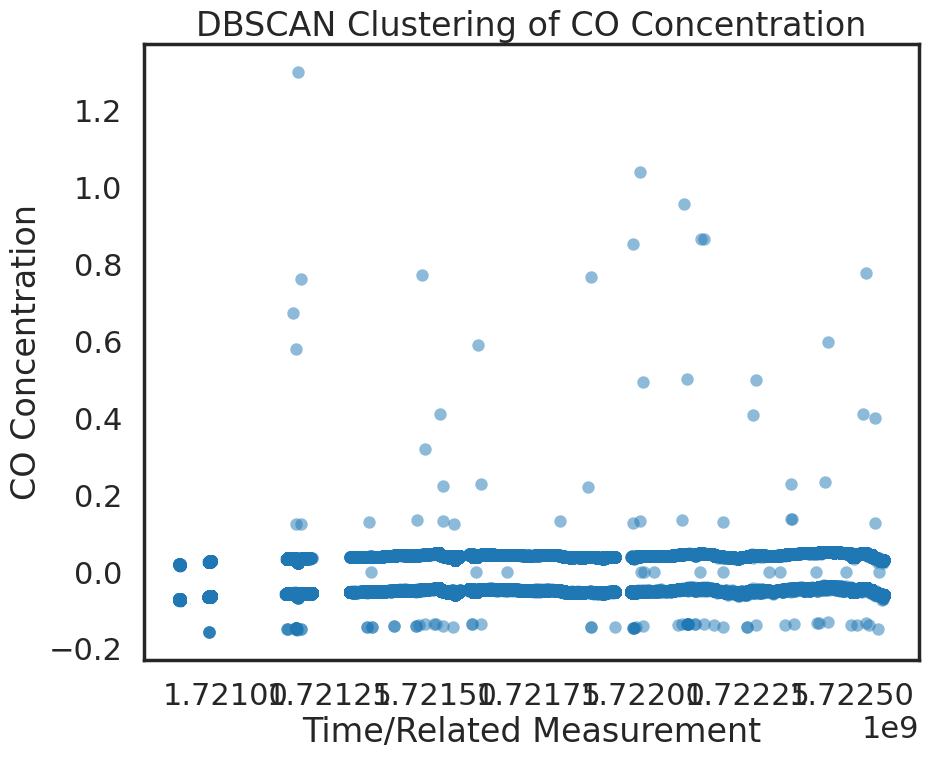

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(data.T[0], data.T[1], cmap='jet', **plot_kwds)
plt.title("DBSCAN Clustering of CO Concentration")
plt.xlabel("Time/Related Measurement")
plt.ylabel("CO Concentration")
plt.show()

In [7]:
df = df_O3
# df = df_NO
df['label'] = 0
df['label'] = ((df['_value'] > -0.1) & (df['_value'] < 0.1)).astype(int)
# df.to_csv('NO.csv')
df.to_csv('O3_labelled.csv')

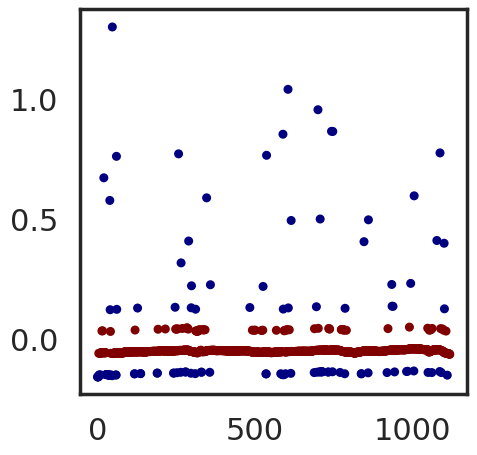

In [9]:
# df = pd.read_csv('/mnt/c_disk/navaneeth/Gas_Anomaly/NO.csv')
df = pd.read_csv('O3_labelled.csv')
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1].sample(n=1000, random_state=42)

data = pd.concat([df_0, df_1]).sort_index()
data['_time'] = pd.to_datetime(df['_time'])
data = data.sort_values('_time')
data['ordinal_time'] = range(1, len(data) + 1)

plt.figure(figsize=(5,5))
plt.scatter(data['ordinal_time'],data['_value'], c = data['label'], s = 20, cmap='jet')

In [3]:
X = data['_value'].values
y = data['label'].values


In [4]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [5]:
print(y)

[0 0 0 ... 1 1 1]


In [6]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

Accuracy (wide): 0.90
Accuracy (wide): 0.91
Accuracy (wide): 0.92
Accuracy (wide): 0.92
Accuracy (wide): 0.90
Accuracy (deep): 1.00
Accuracy (deep): 1.00
Accuracy (deep): 1.00
Accuracy (deep): 1.00
Accuracy (deep): 1.00
Wide: 91.05% (+/- 0.90%)
Deep: 100.00% (+/- 0.00%)
Retrain a deep model
Final model accuracy: 100.00%
-0.04314297065138817 -> [0.96519387] (expected [1.])
0.032499149441719055 -> [0.94010264] (expected [1.])
-0.054099589586257935 -> [0.9487292] (expected [1.])
-0.05192961543798447 -> [0.95248914] (expected [1.])
-0.04314297065138817 -> [0.96519387] (expected [1.])


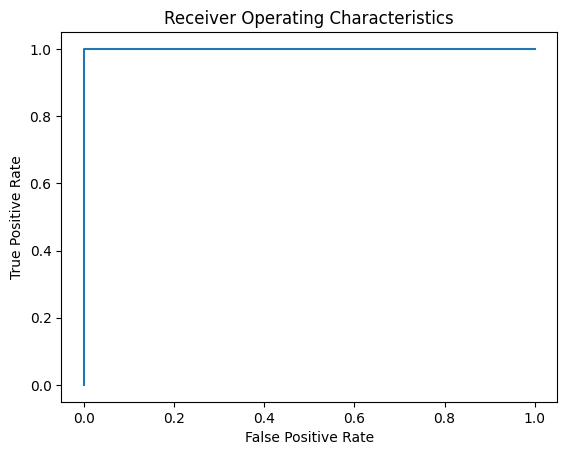

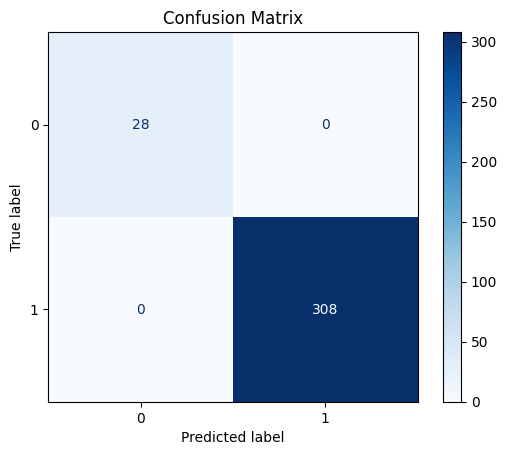

In [8]:
# Define Wide and Deep models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 180)  # Input size is 1
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 60)  # Input size is 1
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    best_acc = -np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # Reshape X_batch to (batch_size, 1)
                X_batch = X_batch.view(-1, 1)

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update weights
                optimizer.step()

                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(loss=float(loss), acc=float(acc))

        # evaluate accuracy at end of each epoch
        model.eval()
        X_val = X_val.view(-1, 1)  # Reshape X_val to (batch_size, 1)
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []   #m,b,mjb,m dddddddddddd bnbcjhfjyhgfv/#
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

# Function to compute and display confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.view(-1, 1)  # Reshape for model input
        y_pred = model(X_test).round().detach().numpy()
        y_test = y_test.detach().numpy()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the final model and plot confusion matrix
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test[i:i+1].view(-1, 1)
        y_pred = model(X_sample)
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    X_test_reshaped = X_test.view(-1, 1)
    y_pred = model(X_test_reshaped)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred.detach().numpy())
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test)

336
118


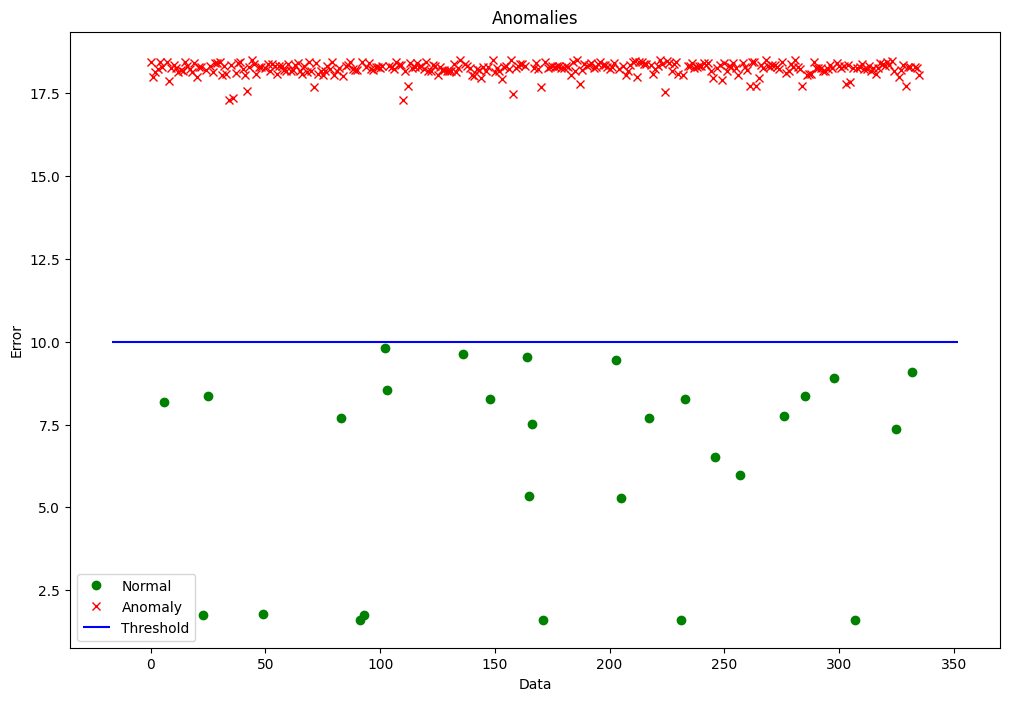

In [11]:
threshold=10
# y_pred1 = model(X_test_reshaped)
y_dist = np.linalg.norm(X_test - y_pred.detach().numpy(), axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]

error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)


print(len(error))
print(len(df_0['label']))
groupsDF = pd.DataFrame({'error': error,'true': y_test.reshape(-1)}).groupby('true')

figure, axes = plt.subplots(figsize=(12, 8))



for name, group in groupsDF:
    axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
axes.legend()
        
plt.title("Anomalies")
plt.ylabel("Error")
plt.xlabel("Data")
plt.show()
